In [30]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import Model

In [5]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
print(data_dir)
data_dir = pathlib.Path(data_dir,"flower_photos").with_suffix('')
print(data_dir)

C:\Users\vova\.keras\datasets\flower_photos_extracted
C:\Users\vova\.keras\datasets\flower_photos_extracted\flower_photos


In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


641


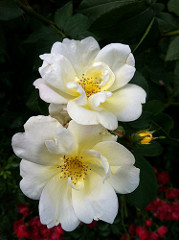

In [7]:
roses = list(data_dir.glob('roses/*'))
print(len(roses))
PIL.Image.open(str(roses[0]))

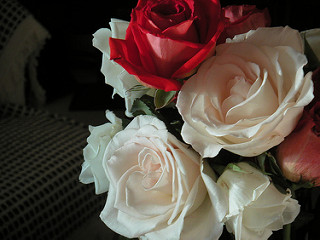

In [8]:
PIL.Image.open(str(roses[1]))

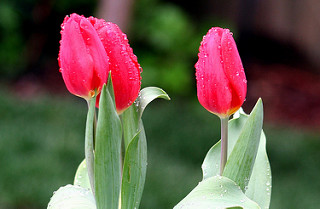

In [9]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

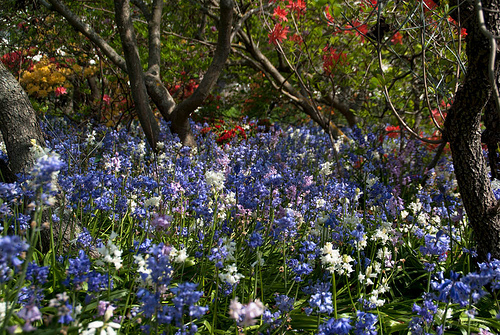

In [10]:
PIL.Image.open(str(tulips[1]))

In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


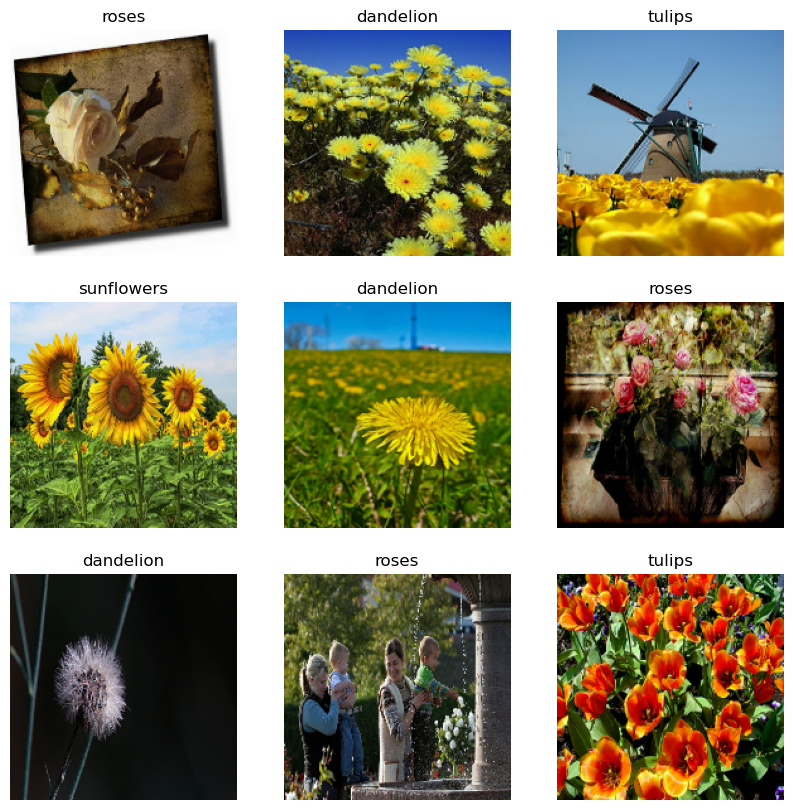

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

4.233566e-06 0.9543138


In [28]:
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model_old = MyModel()

In [31]:
#num_classes = len(class_names)

#model = Sequential([
#  tf.keras.Input(shape=(img_height, img_width, 3)),
#  layers.Rescaling(1./255),
#  layers.Conv2D(16, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Conv2D(32, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Conv2D(64, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Flatten(),
#  layers.Dense(128, activation='relu'),
#  layers.Dense(num_classes)
#])
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(16, 3, activation='relu')
    self.conv2 = Conv2D(32, 3, padding='same', activation='relu')
    self.conv3 = Conv2D(64, 3, padding='same', activation='relu')
    self.mp = MaxPooling2D()
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.mp(x)
    x = self.conv2(x)
    x = self.mp(x)
    x = self.conv3(x)
    x = self.mp(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [32]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [33]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [34]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [35]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [36]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_state()
  train_accuracy.reset_state()
  test_loss.reset_state()
  test_accuracy.reset_state()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in val_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result():0.2f}, '
    f'Accuracy: {train_accuracy.result() * 100:0.2f}, '
    f'Test Loss: {test_loss.result():0.2f}, '
    f'Test Accuracy: {test_accuracy.result() * 100:0.2f}'
  )

Epoch 1, Loss: 29.55, Accuracy: 32.43, Test Loss: 1.25, Test Accuracy: 50.54
Epoch 2, Loss: 1.06, Accuracy: 59.74, Test Loss: 1.11, Test Accuracy: 55.86
Epoch 3, Loss: 0.68, Accuracy: 74.80, Test Loss: 1.20, Test Accuracy: 54.63
Epoch 4, Loss: 0.41, Accuracy: 86.58, Test Loss: 1.52, Test Accuracy: 55.86
Epoch 5, Loss: 0.26, Accuracy: 91.18, Test Loss: 1.53, Test Accuracy: 55.18
